In [ ]:
# http://127.0.0.1:16808/lab?token=3b30677a66c7a27927bb717f152b990f18bf8998c9644b1f
import simpsom as sps
from ipywidgets import IntProgress, HTML
from itertools import product
import scipy.linalg as linalg
from hmmlearn.hmm import GaussianHMM
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle, Patch
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize, CenteredNorm, LogNorm, to_hex
# from metpy import calc as mcalc
# from metpy import interpolate as minterpolate
# from metpy.units import units
# from nco import Nco
# import hvplot.xarray # noqa
# import panel.widgets as pnw
# import panel as pn
# pn.extension()
# import holoviews as hv
# from bokeh.resources import INLINE
from definitions import *
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['animation.ffmpeg_path'] = '/home/hugo/mambaforge-pypy3/envs/env/bin/ffmpeg'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Barriopedro

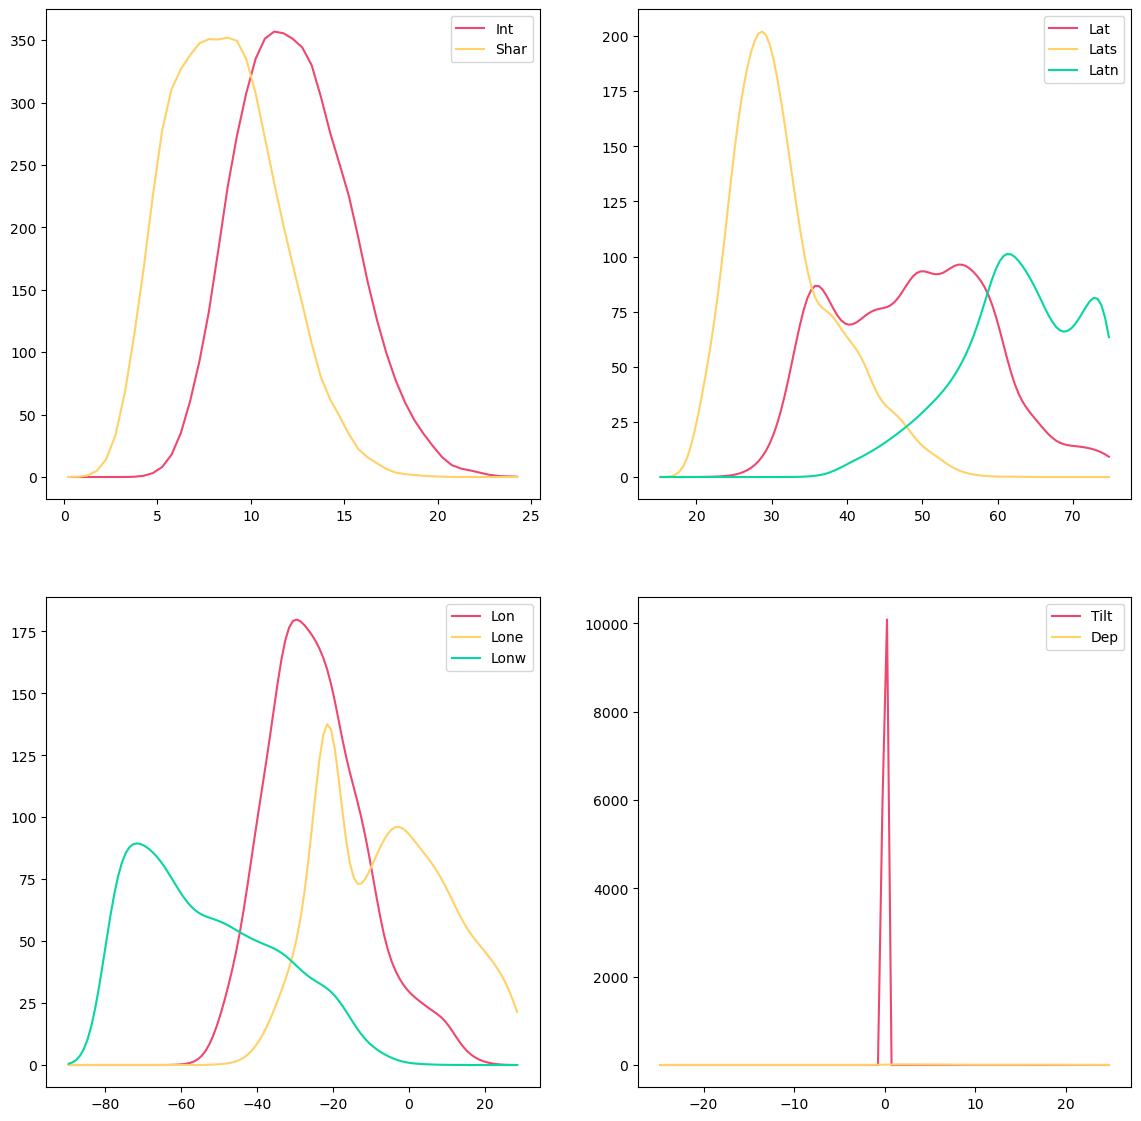

In [2]:
exp_u = ZooExperiment('ERA5', None, -80, 40, 20, 80)
# exp_u.compute_Zoo(True)
# timeseries, ax, season=None, bins=LATBINS, **kwargs
Zoo = xr.open_dataset(exp_u.get_Zoo_path())
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()
mapping = [
    ["Int", "Shar"],
    ["Lat", "Lats", "Latn"],
    ["Lon", "Lone", "Lonw"],
    ["Tilt", "Dep"],
]
bins = [WINDBINS, LATBINS, LONBINS, DEPBINS]
for i, group in enumerate(mapping):
    ax = axes[i]
    for j, key in enumerate(group):
        midpoints, gkde = kde(
            Zoo[key], "DJF", bins[i], scaled=True, return_x=True, bw_method=0.2
        )
        ax.plot(midpoints, gkde, color=COLORS5[j], label=key)
    ax.legend()
plt.show()


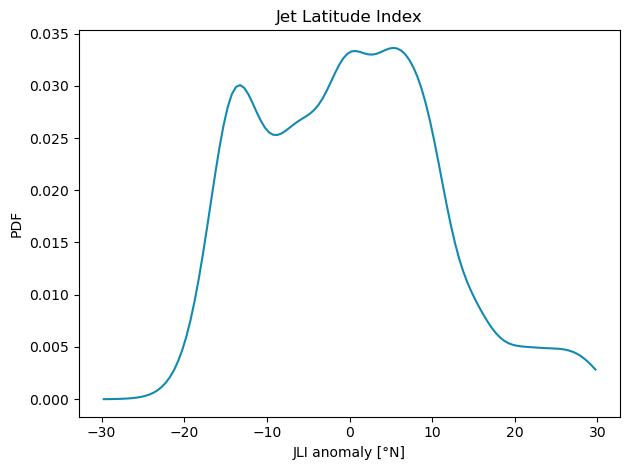

In [3]:
fig, ax = plt.subplots(tight_layout=True)
midpoints, gkde = kde(
    Zoo["Lat_anomaly"],
    "DJF",
    np.arange(-30, 30.1, 0.5),
    scaled=False,
    return_x=True,
    bw_method=0.2,
)
ax.plot(midpoints, gkde, color=COLORS5[-3], label=key)
ax.set_title("Jet Latitude Index")
ax.set_xlabel("JLI anomaly [°N]")
ax.set_ylabel("PDF")
plt.savefig("Figures/JLI_winter.png")


In [4]:
fig, ax = plt.subplots(tight_layout=True)
midpoints, gkde = kde(
    Zoo["Lat_anomaly"],
    "JJA",
    np.arange(-30, 30.1, 0.5),
    scaled=False,
    return_x=True,
    bw_method=0.2,
)
ax.plot(midpoints, gkde, color=COLORS5[-3], label=key)
ax.set_title("Jet Latitude Index")
ax.set_xlabel("JLI anomaly [°N]")
ax.set_ylabel("PDF")
plt.savefig("Figures/JLI_summer.png")


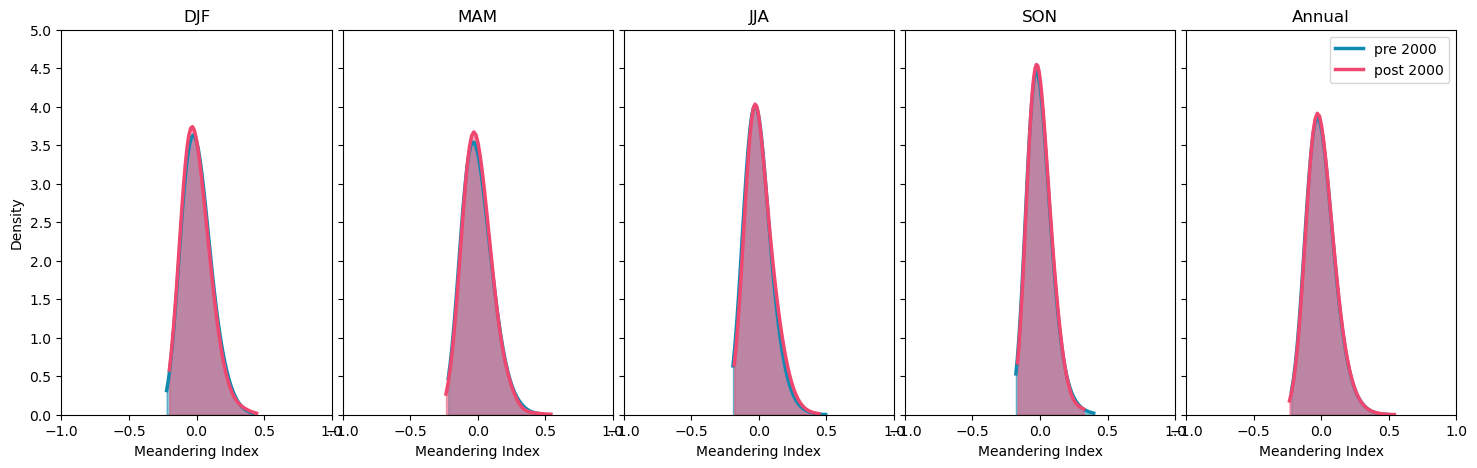

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
daM = Zoo['Mea_detrended']
early = daM.isel(time=(daM.time.dt.year < 2000))
recent = daM.isel(time=(daM.time.dt.year >= 2000))
fig.subplots_adjust(wspace=0.04)
for i, season in enumerate(["DJF", "MAM", "JJA", "SON", "Annual"]):
    kde_early = kde(early, season, 50, scaled=False, return_x=True)
    kde_recent = kde(recent, season, 50, scaled=False, return_x=True)
    axes[i].plot(*kde_early, label="pre 2000", color=COLORS5[3], lw=2.5)
    axes[i].plot(*kde_recent, label="post 2000", color=COLORS5[0], lw=2.5)
    axes[i].fill_between(kde_early[0], 0, kde_early[1], color=COLORS5[3], alpha=0.5)
    axes[i].fill_between(kde_recent[0], 0, kde_recent[1], color=COLORS5[0], alpha=0.5)
    axes[i].set_title(season)
    axes[i].set_xlabel("Meandering Index")
    axes[i].set_yticks(np.arange(0, 5.1, 0.5))
    axes[i].set_xlim([-1, 1])
    axes[i].set_ylim([0, 5])
axes[0].set_ylabel("Density")
axes[-1].legend()
plt.draw()
plt.savefig("Figures/meandering.png")

## LDT on Lat, Int

In [ ]:
Zoo = xr.open_dataset(f"{DATADIR}/ERA5/processed/BarriopedroZooDetrended.nc")
winter = np.isin(Zoo.time.dt.month, [1, 2, 12])
JLI = Zoo["Lat_anomaly"].isel(time=winter)
JSI = Zoo["Int_anomaly"].isel(time=winter)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, sharey=False)
bins = [np.arange(-10, 10.5, 0.25), np.arange(-8, 8.01, 0.25)]
for i, series in enumerate([JLI, JSI]):
    ax = axes[i]
    for j, n in enumerate(range(15, 121, 15)):
        coarsened = series.rolling(time=n).mean()

        x, gkde = kde(coarsened, bins=bins[i], return_x=True)
        y = -np.log(gkde) / n
        y -= np.amin(y)
        ax.plot(x, y, color=COLORS10[j], label=f"n={n}")
    ax.set_title(series.name)
    ax.legend()


In [ ]:
coarsened = JSI.coarsen(time=60, boundary="trim").mean()
x, gkde = kde(coarsened, bins=np.arange(-10, 10.01, 0.1), return_x=True)
y = -np.log(gkde) / n
a, b, c = np.polyfit(x, y, deg=2, w=1 / y)


In [ ]:
plt.plot(x, y)
plt.plot(x, a * x * x + b * x + c)


In [ ]:
plt.plot(x, gkde)
x2 = np.linspace(-25, 25, 201)
plt.plot(x, np.exp(-n * (a * x * x + b * x + c)))
plt.plot(x, normal_dist(loc=np.mean(coarsened), scale=np.std(coarsened)).pdf(x))


# Stationarity

### Plot Zoo Autocorrelation:

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 16), tight_layout=True)
axes = axes.flatten(order="F")
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"  # daint
autocorrs = xr.open_dataset(f"{datadir}/Zoo_autocorrs.nc")
howmany = len(autocorrs.coords["lag"])
newlist = []
for key in list(Zoo.data_vars.keys())[:11]:
    for suffix in ["_anomaly"]:
        newlist.append(f"{key}{suffix}")
telatex = r"$T^e_{\rho}$"
tdlatex = r"$T^d_{\rho}$"
tclatex = r"$T^c_{\rho}$"
lw = 2
for i, varname in enumerate(newlist):
    te = np.argmax(autocorrs[varname].values <= 1 / np.exp(1))
    td = 1 + 2 * np.sum(autocorrs[varname])
    tc = 1 + np.sum(
        autocorrs[varname] * (1 - np.arange(1, howmany + 1) / (howmany + 1))
    )
    axes[i].plot(np.arange(howmany), autocorrs[varname], color=COLORS5[0], lw=lw)
    axes[i].plot([te, te], [0, 1], label=telatex, color=COLORS5[2], lw=lw)
    axes[i].plot([tc, tc], [0, 1], label=tclatex, color=COLORS5[3], lw=lw)
    axes[i].plot([td, td], [0, 1], label=tdlatex, color=COLORS5[4], lw=lw)
    axes[i].grid()
    axes[i].legend()
    axes[i].set_title(
        f"{varname}, {telatex}={te}, {tdlatex}={td:.3f}, {tclatex}={tc:.3f}"
    )
    axes[i].set_ylabel("Autocorrelation")
    axes[i].set_xlabel("Lag time [days]")
plt.savefig("Figures/zoo_autocorrs.png")


### Predict hot spells

In [ ]:
n_clu = 3
variable = "Wind"
level = "300"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "rb") as handle:
    results = pkl.load(handle)


In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells_clusters = {}
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
detrended = xr.open_dataarray(f"{path}/detrended.nc")  # Don't limit to summer here
minus = 21
plus = 5
for j, key in enumerate(keys):
    dates = np.sort(list_of_dates[:, j])
    dates = dates[
        ~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))
    ]
    hotspells_clusters[key] = []
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D") + np.timedelta64(9, "h")
        tend = date + np.timedelta64(plus, "D") + np.timedelta64(9, "h")
        to_predict = detrended.sel(time=pd.date_range(tsta, tend, freq="1D"))
        to_predict = to_predict.values.reshape(len(to_predict.time), -1)
        hotspells_clusters[key].append(results.predict(to_predict))
    hotspells_clusters[key] = xr.DataArray(
        np.stack(hotspells_clusters[key]).transpose(),
        coords={"time": np.arange(-minus, plus + 1), "hotspell": dates},
    )
with open(f"{path}/hotspells_clusters.pkl", "wb") as handle:
    pkl.dump(hotspells_clusters, handle)


In [ ]:
%matplotlib inline
with open(f"{path}/hotspells_clusters.pkl", "rb") as handle:
    hotspells_clusters = pkl.load(handle)
hot_time = hotspells_clusters["South"].time.values
to_plot = np.zeros((2, len(keys), 2 * len(hot_time)))
cmaps = ["Blues", "Greens", "Reds", "Purples"]
for i in range(3):
    for j, (key, value) in enumerate(hotspells_clusters.items()):
        to_plot[int(i <= 1), j, (i % 2)::2] = i + (value == i).mean(dim="hotspell").values
class HandlerColormap(HandlerBase): # https://stackoverflow.com/questions/55501860/how-to-put-multiple-colormap-patches-in-a-matplotlib-legend
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle(
                [xdescent + i * width / self.num_stripes, ydescent], 
                width / self.num_stripes, 
                height, 
                fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                transform=trans,
            )
            stripes.append(s)
        return stripes

cmaps = [mpl.colormaps[cmap].resampled(256) for cmap in ["Blues", "Greens", "Reds", "Purples"]]
cmap = ListedColormap(np.concatenate([cmap(np.linspace(0, 1, 256)) for cmap in cmaps]))

fig, axes = plt.subplots(len(keys), 1, figsize=(15, 5))
norm = Normalize(0, len(cmaps))
for j, ax in enumerate(axes):
    ax.set_yticks([1])
    ax.set_yticklabels([list(hotspells_clusters.keys())[j]])
    if j==len(axes) - 1:
        ax.set_xticks(np.arange(hot_time[0] + 0.5, hot_time[-1] + 1.5))
        ax.set_xticklabels(np.arange(hot_time[0], hot_time[-1] + 1))
        ax.set_xlabel("Days around center")
    else:
        ax.set_xticks([])
    ax.set_frame_on(False)
    for i in range(2):
        ax.pcolormesh(
            np.arange(hot_time[0], hot_time[-1] + 1.1, .5), 
            np.arange(3), to_plot[:, j].reshape(2, len(hot_time) * 2), 
            cmap=cmap, norm=norm
        )
    ax.vlines(np.arange(hot_time[0] + 1, hot_time[-1] + 1), 0, 2, color="white", lw=4)
cmap_handles = [Rectangle((0, 0), 3, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, [HandlerColormap(cm, num_stripes=20) for cm in cmaps]))
cmap_labels = [f"regime {k + 1}" for k in range(4)]
axes[-1].legend(
    handles=cmap_handles, 
    labels=cmap_labels, 
    handler_map=handler_map, 
    fontsize=12,
    bbox_to_anchor=(1.13, 4.2),
    loc="upper right",
)
plt.subplots_adjust(hspace=0.1)

In [ ]:
%matplotlib inline
with open(f"{path}/hotspells_clusters.pkl", "rb") as handle:
    hotspells_clusters = pkl.load(handle)
with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "rb") as handle:
    results = pkl.load(handle)
abs_freq = [np.mean(results.labels_ == i) for i in range(n_clu)]
hot_time = hotspells_clusters["South"].time.values
to_plot = np.zeros((n_clu, len(hotspells_clusters), len(hot_time)))
cmaps = ["Blues", "Greens", "Reds", "Purples"]
for i in range(n_clu):
    for j, (key, value) in enumerate(hotspells_clusters.items()):
        to_plot[i, j] = abs_freq[i] - (value == i).mean(dim="hotspell").values

fig, axes = plt.subplots(len(hotspells_clusters), 1, figsize=(15, 8), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0, left=0.06)
for j, key in enumerate(hotspells_clusters):
    ax = axes[j]
#     ax.spines[["left", "right"]].set_visible(False)
    for i in range(n_clu):
        ax.plot(hot_time, to_plot[i, j], lw=2, color=COLORS5[i], label=f"Regime {i + 1}")
    ax.set_ylim([-0.5, 0.5])
    ax.set_yticks([-0.25, 0, 0.25])
    ax.set_yticklabels([-25, 0, 25])
    ax.text(-20.8, 0.21, key, fontweight="bold")
    ax.grid()
fig.supylabel('Regime relative occurence [%]')
ax.set_xlabel("Time around center [Days]")
ax.set_xlim([-21, 5])
ax.legend(bbox_to_anchor=(1.12, 3.53),)

## Z500

In [ ]:
n_clu = 4
variable = "Wind"
level = "300"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
# path = detrend(dataset, variable, level, region)
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season == "JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
results = KMeans(n_clu, n_init="auto").fit(tbt)
with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "wb") as handle:
    pkl.dump(results, handle)


In [ ]:
variable = "Geopotential"
level = "500"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "rb") as handle:
    results = pkl.load(handle)
n_clu = len(results.cluster_centers_)
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season == "JJA")
centers = xr.DataArray(
    results.cluster_centers_.reshape(n_clu, *thisda.shape[1:]),
    coords={
        "cluster": np.arange(n_clu),
        "lat": thisda.lat.values,
        "lon": thisda.lon.values,
    },
) / np.sqrt(degcos(thisda.lat))
to_plot = [centers.isel(cluster=i) for i in range(n_clu)]
fig, axes, cbar = clusterplot(
    2, 2, to_plot, 11, 150, cbar_ylabel="Z500 [m]", clabels=False
)
plt.show()


### Predict hot spells

In [ ]:
variable = "Wind"
level = "300"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
with open(f"{path}/kmeans_ERA5_detrended_summer.pkl", "rb") as handle:
    results = pkl.load(handle)


In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells_clusters = {}
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
detrended = xr.open_dataarray(f"{path}/detrended.nc")  # Don't limit to summer here
minus = 21
plus = 5
for j, key in enumerate(keys):
    dates = np.sort(list_of_dates[:, j])
    dates = dates[
        ~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))
    ]
    hotspells_clusters[key] = []
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D") + np.timedelta64(9, "h")
        tend = date + np.timedelta64(plus, "D") + np.timedelta64(9, "h")
        to_predict = detrended.sel(time=pd.date_range(tsta, tend, freq="1D"))
        to_predict = to_predict.values.reshape(len(to_predict.time), -1)
        hotspells_clusters[key].append(results.predict(to_predict))
    hotspells_clusters[key] = xr.DataArray(
        np.stack(hotspells_clusters[key]).transpose(),
        coords={"time": np.arange(-minus, plus + 1), "hotspell": dates},
    )
with open(f"{path}/hotspells_clusters.pkl", "wb") as handle:
    pkl.dump(hotspells_clusters, handle)


In [ ]:
%matplotlib inline
with open(f"{path}/hotspells_clusters.pkl", "rb") as handle:
    hotspells_clusters = pkl.load(handle)
hot_time = hotspells_clusters["South"].time.values
to_plot = np.zeros((n_clu // 2, len(keys), 2 * len(hot_time)))
cmaps = ["Blues", "Greens", "Reds", "Purples"]
for i in range(4):
    for j, (key, value) in enumerate(hotspells_clusters.items()):
        to_plot[int(i <= 1), j, (i % 2)::2] = i + (value == i).mean(dim="hotspell").values
class HandlerColormap(HandlerBase): # https://stackoverflow.com/questions/55501860/how-to-put-multiple-colormap-patches-in-a-matplotlib-legend
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle(
                [xdescent + i * width / self.num_stripes, ydescent], 
                width / self.num_stripes, 
                height, 
                fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                transform=trans,
            )
            stripes.append(s)
        return stripes

cmaps = [mpl.colormaps[cmap].resampled(256) for cmap in ["Blues", "Greens", "Reds", "Purples"]]
cmap = ListedColormap(np.concatenate([cmap(np.linspace(0, 1, 256)) for cmap in cmaps]))

fig, axes = plt.subplots(len(keys), 1, figsize=(15, 5))
norm = Normalize(0, len(cmaps))
for j, ax in enumerate(axes):
    ax.set_yticks([1])
    ax.set_yticklabels([list(hotspells_clusters.keys())[j]])
    if j==len(axes) - 1:
        ax.set_xticks(np.arange(hot_time[0] + 0.5, hot_time[-1] + 1.5))
        ax.set_xticklabels(np.arange(hot_time[0], hot_time[-1] + 1))
        ax.set_xlabel("Days around center")
    else:
        ax.set_xticks([])
    ax.set_frame_on(False)
    for i in range(2):
        ax.pcolormesh(
            np.arange(hot_time[0], hot_time[-1] + 1.1, .5), 
            np.arange(3), to_plot[:, j].reshape(2, len(hot_time) * 2), 
            cmap=cmap, norm=norm
        )
    ax.vlines(np.arange(hot_time[0] + 1, hot_time[-1] + 1), 0, 2, color="white", lw=4)
cmap_handles = [Rectangle((0, 0), 3, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, [HandlerColormap(cm, num_stripes=20) for cm in cmaps]))
cmap_labels = [f"regime {k + 1}" for k in range(4)]
axes[-1].legend(
    handles=cmap_handles, 
    labels=cmap_labels, 
    handler_map=handler_map, 
    fontsize=12,
    bbox_to_anchor=(1.13, 4.2),
    loc="upper right",
)
plt.subplots_adjust(hspace=0.1)

In [ ]:
%matplotlib inline
with open(f"{path}/hotspells_clusters.pkl", "rb") as handle:
    hotspells_clusters = pkl.load(handle)
with open(f"{path}/kmeans_ERA5_detrended.pkl", "rb") as handle:
    results = pkl.load(handle)
n_clu = 4
abs_freq = [np.mean(results.labels_ == i) for i in range(n_clu)]
hot_time = hotspells_clusters["South"].time.values
to_plot = np.zeros((n_clu, len(hotspells_clusters), len(hot_time)))
cmaps = ["Blues", "Greens", "Reds", "Purples"]
for i in range(n_clu):
    for j, (key, value) in enumerate(hotspells_clusters.items()):
        to_plot[i, j] = abs_freq[i] - (value == i).mean(dim="hotspell").values

fig, axes = plt.subplots(len(hotspells_clusters), 1, figsize=(15, 8), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0, left=0.06)
for j, key in enumerate(hotspells_clusters):
    ax = axes[j]
#     ax.spines[["left", "right"]].set_visible(False)
    for i in range(n_clu):
        ax.plot(hot_time, to_plot[i, j], lw=2, color=COLORS5[i], label=f"Regime {i + 1}")
    ax.set_ylim([-0.5, 0.5])
    ax.set_yticks([-0.25, 0, 0.25])
    ax.set_yticklabels([-25, 0, 25])
    ax.text(-20.8, 0.21, key, fontweight="bold")
    ax.grid()
fig.supylabel('Regime relative occurence [%]')
ax.set_xlabel("Time around center [Days]")
ax.set_xlim([-21, 5])
ax.legend(bbox_to_anchor=(1.12, 3.53),)

# PCA

## S300

In [ ]:
n_components = 20
variable = "Wind"
level = "300"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season == "JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
pca_results = pca(n_components=n_components, whiten=True).fit(tbt)


In [ ]:
centers = xr.DataArray(
    pca_results.components_.reshape(n_components, *thisda.shape[1:]),
    coords={
        "component": np.arange(n_components),
        "lat": thisda.lat.values,
        "lon": thisda.lon.values,
    },
) / np.sqrt(degcos(thisda.lat))
to_plot = [centers.isel(component=i) for i in range(n_components)]
levels = 10
lower, upper = -0.045, 0.045
fig, axes, cbar = clusterplot(6, 4, to_plot, levels, 0.045)


In [ ]:
with open(f"{path}/pca_ERA5_detrended_summer.pkl", "wb") as handle:
    pkl.dump(pca_results, handle)


## Z500

In [ ]:
from sklearn.decomposition import PCA as pca

n_components = 20
variable = "Geopotential"
level = "500"
region = "north_atlantic"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
thisda = xr.open_dataarray(f"{path}/detrended.nc")
thisda = thisda.isel(time=thisda.time.dt.season == "JJA")
tbt = (thisda * np.sqrt(degcos(thisda.lat))).values.reshape(len(thisda.time), -1)
pca_results = pca(n_components=n_components, whiten=True).fit(tbt)


In [ ]:
centers = xr.DataArray(
    pca_results.components_.reshape(n_components, *thisda.shape[1:]),
    coords={
        "component": np.arange(n_components),
        "lat": thisda.lat.values,
        "lon": thisda.lon.values,
    },
) / np.sqrt(degcos(thisda.lat))
projection = ccrs.LambertConformal(
    central_longitude=np.mean(thisda.lon.values),
)
lon = thisda["lon"].values
lat = thisda["lat"].values
fig, axes = plt.subplots(
    5,
    4,
    figsize=(20, 25),
    subplot_kw={"projection": projection},
    constrained_layout=True,
)
extent = [np.amin(lon), np.amax(lon), np.amin(lat), np.amax(lat)]
boundary = make_boundary_path(*extent)
levels = 10
cmap = "seismic"
lower, upper = -0.045, 0.045
levels = np.delete(
    np.append(np.linspace(lower, 0, levels), np.linspace(0, upper, levels)),
    [levels - 1, levels],
)
cmap = cm.get_cmap(cmap)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend="both")
im = cm.ScalarMappable(norm=norm, cmap=cmap)
axes = axes.flatten()
for i in range(n_components):
    axes[i].contourf(
        lon,
        lat,
        centers.isel(component=i),
        transform=ccrs.PlateCarree(),
        levels=levels,
        cmap=cmap,
        norm=norm,
        extend="both",
    )
    axes[i].contour(
        lon,
        lat,
        centers.isel(component=i),
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors="k",
    )
    axes[i].set_boundary(boundary, transform=ccrs.PlateCarree())
    axes[i].add_feature(COASTLINE)
    axes[i].add_feature(BORDERS)
    axes[i].set_title(f"{pca_results.explained_variance_ratio_[i] * 100:.2f} %")
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), spacing="proportional")
cbar.ax.set_ylabel("Z500 [m]")
# _ = cbar.ax.set_yticks(np.concatenate([np.arange(-0.045, -0.004, 0.005), np.arange(0.005, 0.046, 0.005)]))
plt.show()


In [ ]:
with open(f"{path}/pca_ERA5_detrended_summer.pkl", "wb") as handle:
    pkl.dump(pca_results, handle)


# OPP from EOFs (optimal $T_1$, TODO $T_2$) 

## S300

In [20]:
eigenvals, OPPS = exp_som.do_opp(180, 15, True)

DEBUG:root:pca_*_anomaly_JJA.pkl
DEBUG:root:{PosixPath('/storage/scratch/users/hb22g102/ERA5/Wind/300/box_-80_40_20_80/pca_180_anomaly_JJA.pkl'): 180}
DEBUG:root:pca_*_anomaly_JJA.pkl
DEBUG:root:{PosixPath('/storage/scratch/users/hb22g102/ERA5/Wind/300/box_-80_40_20_80/pca_180_anomaly_JJA.pkl'): 180}


In [27]:
net, centers = exp_som.do_som(10, 10, 180, False, True, True)

DEBUG:root:pca_*_anomaly_JJA.pkl
DEBUG:root:{PosixPath('/storage/scratch/users/hb22g102/ERA5/Wind/300/box_-80_40_20_80/pca_180_anomaly_JJA.pkl'): 180}
2023-03-29 17:01:33.805 | INFO     | simpsom.network:__init__:113 - Hexagonal topology.
2023-03-29 17:01:33.808 | INFO     | simpsom.network:_set_weights:195 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
DEBUG:root:[[-0.11995313 -0.04334786  0.14115047 ... -0.0784018   0.04759217
   0.02557129]
 [-0.09774765  0.03514601  0.15832417 ... -0.05971446  0.06892549
   0.02530415]
 [-0.02520805  0.12776795  0.10301613 ... -0.01705864  0.06202919
   0.02771313]
 ...
 [-0.05042438 -0.08961913  0.08019082 ... -0.07069395  0.0014396
   0.07936758]
 [-0.11703555 -0.16841574  0.15137291 ... -0.13669778  0.0131047
   0.05660573]
 [-0.15360713 -0.11384264  0.19207774 ... -0.15673247  0.05229594
   0.07706975]]
DEBUG:root:(100, 180)
DEBUG:root:pca_*_anomaly_JJA.pkl
DEBUG:root:{Pos

In [29]:
net

In [10]:
OPPs_realspace = exp_som.pca_inverse_transform(
    autocorrs[0] @ (invsqrtC0 @ eigenvecs.T),
    n_pcas
)


DEBUG:root:pca_*_anomaly_JJA.pkl
DEBUG:root:{}


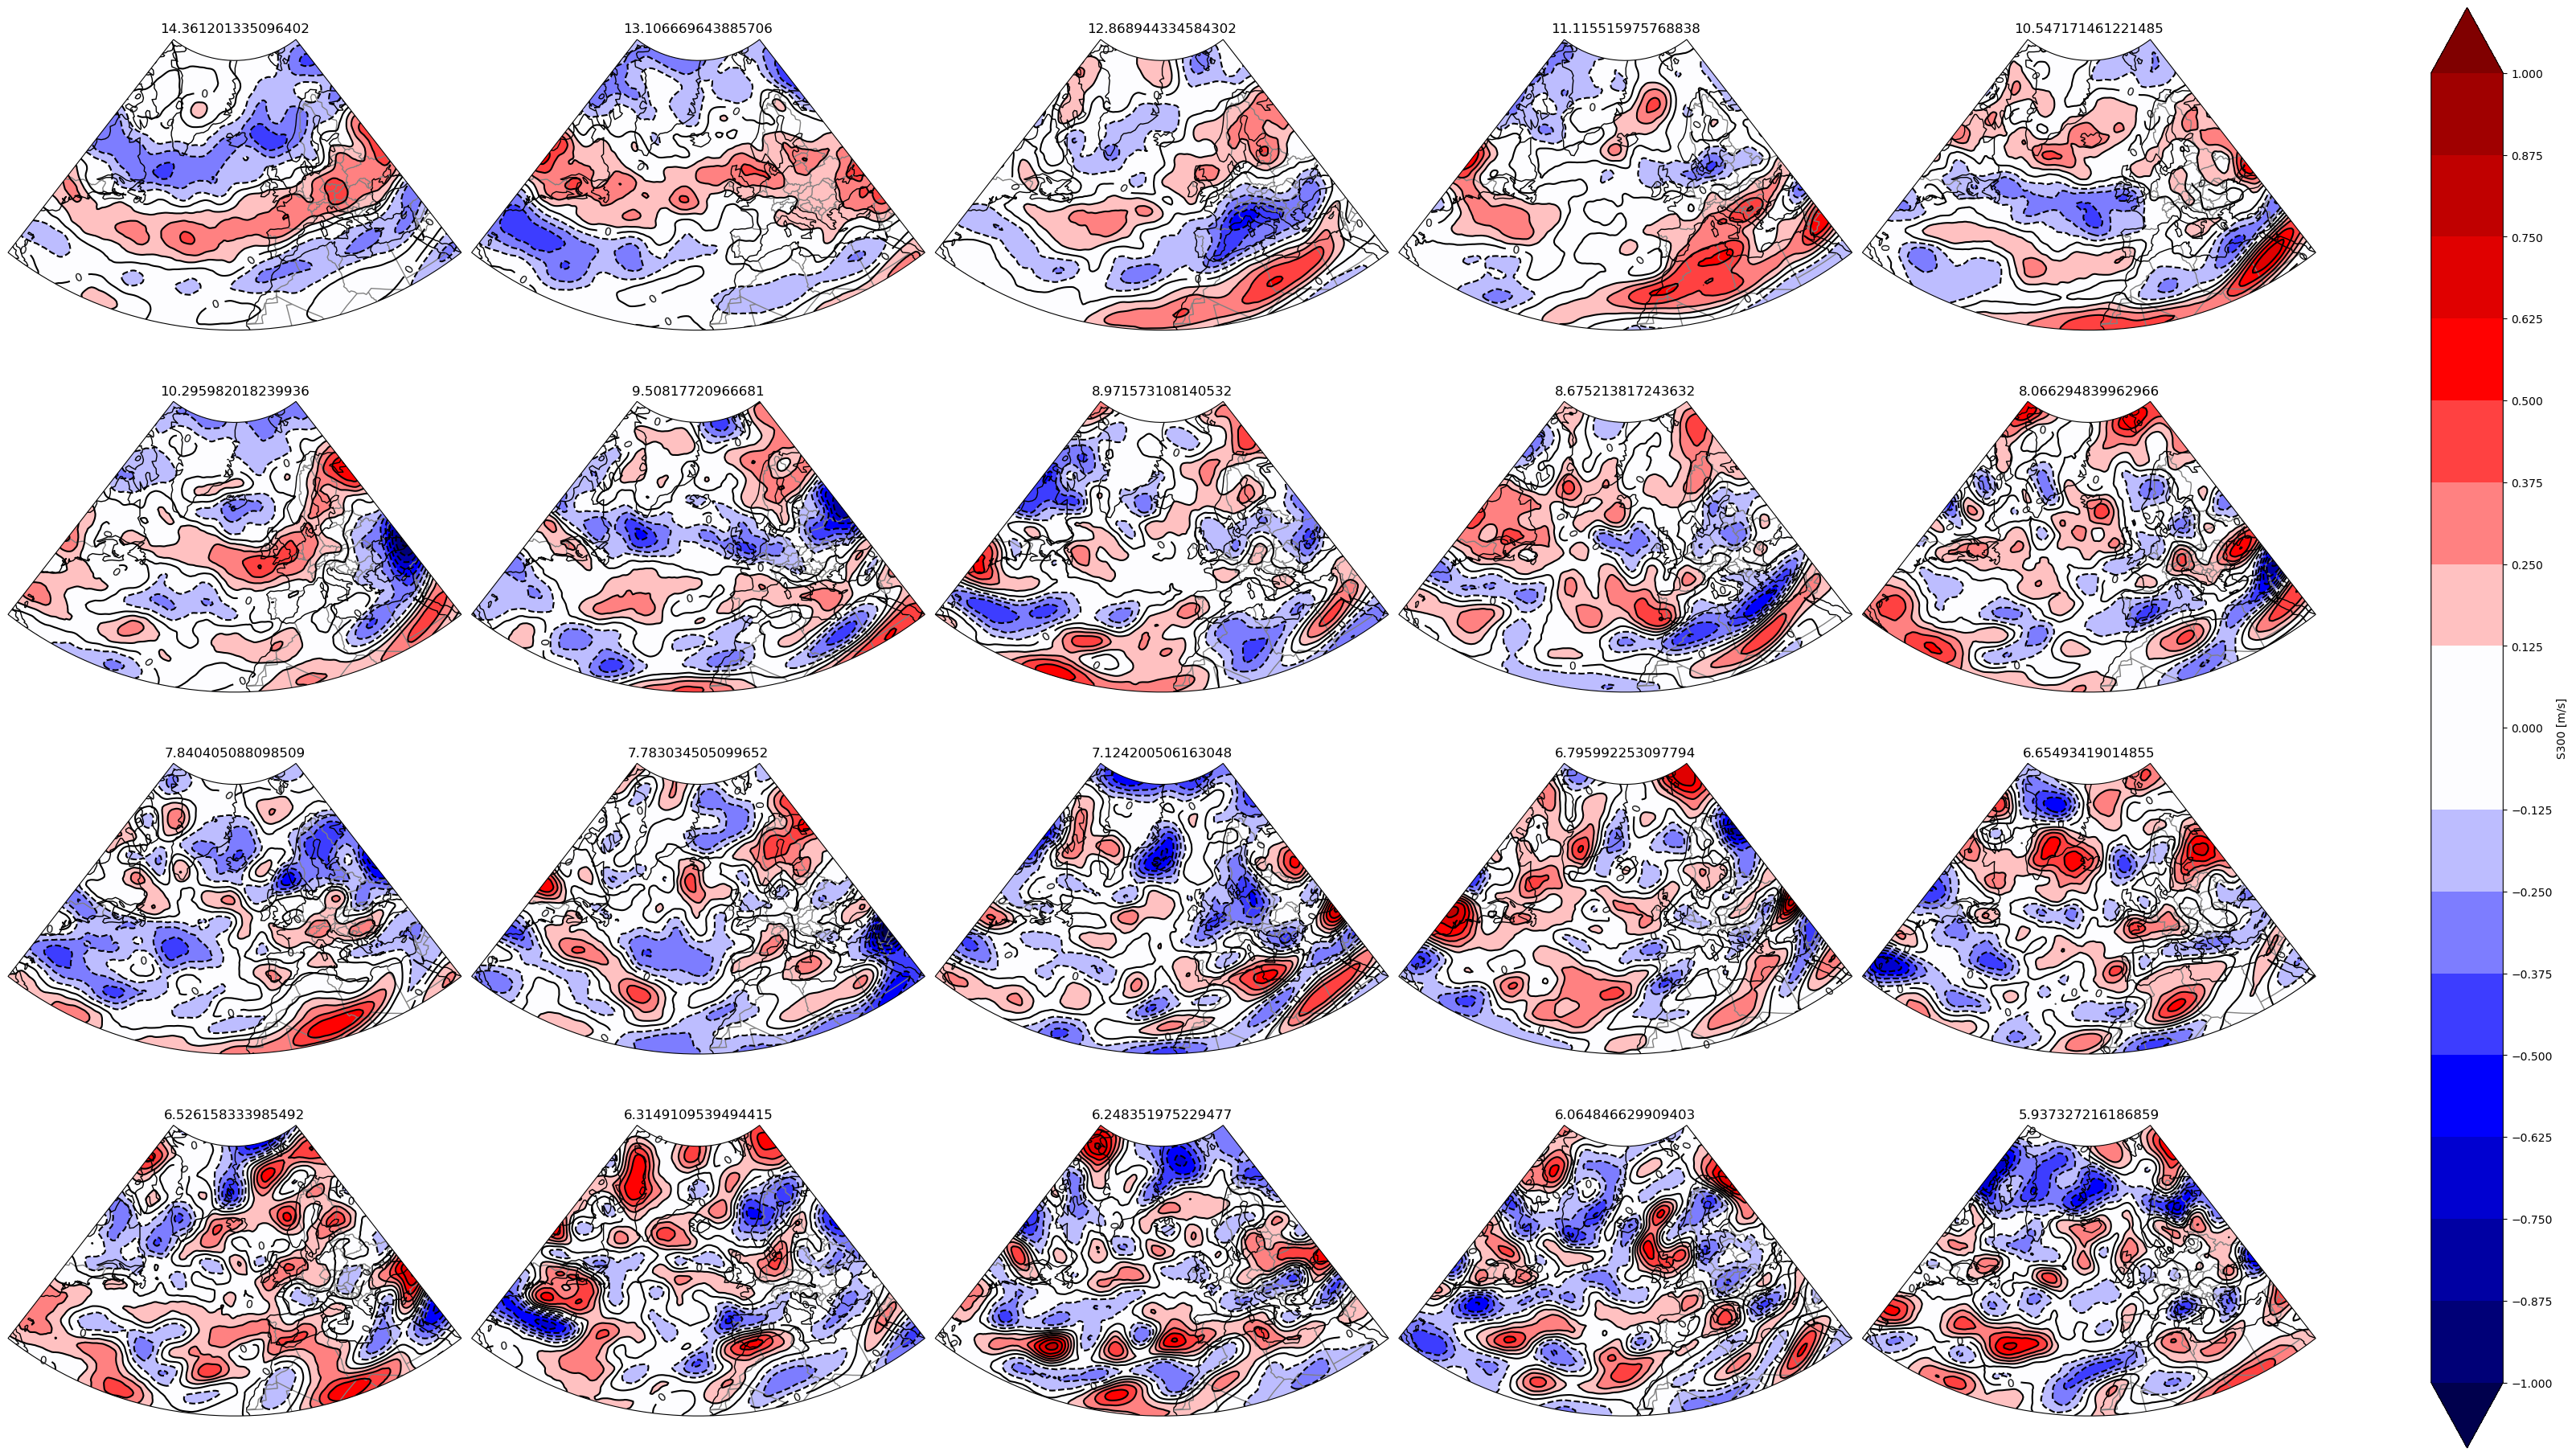

In [107]:
idx = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[idx]
OPPs_realspace = OPPs_realspace[idx]

centers = (
    xr.DataArray(
        OPPs_realspace.reshape(n_components, *thisda.shape[1:]),
        coords={
            "component": np.arange(n_components),
            "lat": thisda.lat.values,
            "lon": thisda.lon.values,
        },
    )
    / np.sqrt(degcos(thisda.lat))
)
to_plot = [centers.isel(component=i) for i in range(n_components)]
fig, axes, cbar = clusterplot(
    4, 5, to_plot[:20], 9, 1, cbar_ylabel="S300 [m/s]", clabels=[0]
)
for i in range(20):
    axes[i].set_title(eigenvals[i])


In [113]:
OPPs = autocorrs[0] @ (invsqrtC0 @ eigenvecs.T)[idx]

In [115]:
projected_on_OPPs = (reduced @ OPPs.T)

## Z500

In [44]:
exp_z = ClusteringExperiment('ERA5', 'Geopotential', '500', None, None, -80, 40, 20, 80, False, 'anomaly', 'JJA')
n_pcas = 180
eigenvals, OPPs = exp_z.do_opp(n_pcas, return_realspace=True)
to_plot = [OPPs.isel(component=i) for i in range(20)]
fig, axes, cbar = clusterplot(
    4, 5, to_plot, 11, 100, cbar_ylabel="Z500 [m]", clabels=[0]
)
for i in range(n_components):
    axes[i].set_title(eigenvals[i])
plt.show()


DEBUG:root:pca_*_anomaly_JJA.pkl
DEBUG:root:{PosixPath('/storage/scratch/users/hb22g102/ERA5/Geopotential/500/box_-80_40_20_80/pca_180_anomaly_JJA.pkl'): 180}
DEBUG:root:pca_*_anomaly_JJA.pkl
DEBUG:root:{PosixPath('/storage/scratch/users/hb22g102/ERA5/Geopotential/500/box_-80_40_20_80/pca_180_anomaly_JJA.pkl'): 180}


ValueError: Dimensions {'component'} do not exist. Expected one or more of ('OPP', 'lat', 'lon')

# Hidden Markov Model

In [ ]:
Zoo = xr.open_dataset(f"{DATADIR}/ERA5/processed/BarriopedroZooDetrended.nc")
Y = Zoo["Lat_detrended"].isel(time=Zoo.time.dt.season == "DJF").values


In [ ]:
n_components = 3
n_sel = 50
n_sam = 4500
means = []
sigmas = []
transmats = []
for i in range(n_sel):
    ghmm = GaussianHMM(n_components=n_components).fit(Y[:, None])
    transmats.append(ghmm.transmat_)
    means.append(ghmm.means_[:, 0])
    sigmas.append(ghmm.covars_[:, 0, 0])
# im = plt.imshow(ghmm.transmat_)
# plt.colorbar(im)


In [ ]:
means = np.stack(means)
sigmas = np.stack(sigmas)
transmats = np.stack(transmats)
idx2 = np.argsort(means, axis=1)
means = np.take_along_axis(means, idx2, axis=1)
sigmas = np.take_along_axis(sigmas, idx2, axis=1)
transmatss = np.take_along_axis(transmats, idx2[:, :, np.newaxis], axis=1)
transmatss = np.take_along_axis(transmatss, idx2[:, np.newaxis, :], axis=2)
mean = np.mean(means, axis=0)
sigma = np.mean(sigmas, axis=0)
transmat = np.mean(transmatss, axis=0)
c = np.real(np.log(np.linalg.eigvals(transmat).astype(np.complex128)))
c[np.isclose(c, 0)] = 0
for i in range(n_components):
    thisnorm = normal_dist(loc=mean[i], scale=np.sqrt(sigma[i]))
    X = np.linspace(thisnorm.ppf(0.005), thisnorm.ppf(0.995), 100)
    plt.plot(X, thisnorm.pdf(X) / n_components, label=f"$c={c[i]:.2f}$")
plt.plot(
    *kde(
        Y,
        season=None,
        bins=np.arange(-30, 30.1, 0.5),
        scaled=False,
        return_x=True,
        bw_method=0.2,
    ),
    label="JLI, KDE",
)
plt.legend()


In [ ]:
meanghmm = GaussianHMM(n_components=3, covariance_type="full")
meanghmm.transmat_ = transmat
meanghmm.means_ = mean.reshape(3, 1)
meanghmm.covars_ = sigma.reshape(3, 1, 1)
meanghmm.startprob_ = [0, 0, 1]


In [ ]:
Zda = xr.open_dataarray(
    f"{DATADIR}/ERA5/Geopotential/500/north_atlantic/detrended.nc"
).isel(time=Zoo.time.dt.season == "DJF")
states = meanghmm.predict(Y.reshape(-1, 1))
to_plot = [Zda.isel(time=states == i).mean(dim="time") for i in range(n_components)]
fig, axes, cbar = clusterplot(
    1, n_components, to_plot, 11, 150, cbar_ylabel="Z500 [m]", cmap="PRGn"
)
plt.show()


In [ ]:
Sda = xr.open_dataarray(f"{DATADIR}/ERA5/Wind/300/box_-90_30_30_80/s_detrended.nc")[
    1:
].isel(time=Zoo.time.dt.season == "DJF")
states = meanghmm.predict(Y.reshape(-1, 1))
to_plot = [Sda.isel(time=states == i).mean(dim="time") for i in range(n_components)]
fig, axes, cbar = clusterplot(1, n_components, to_plot, 7, 12, cbar_ylabel="S300 [m/s]")
plt.show()


## Length of events

In [ ]:
def runs_of_ones_array(
    bits,
):  # https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], bits, [0]))
    # get 1 at run starts and -1 at run ends
    difs = np.diff(bounded)
    (run_starts,) = np.where(difs > 0)
    (run_ends,) = np.where(difs < 0)
    return run_starts, run_ends - run_starts


fig, ax = plt.subplots()
for i in range(meanghmm.n_components):
    thisseq = states == i
    _, durations = runs_of_ones_array(thisseq)
    dur, occu = np.unique(durations, return_counts=True)
    durind = np.argsort(dur)
    dur = dur[durind]
    occu = occu[durind] / np.amax(occu)
    ax.plot(dur, occu, label=f"$\mu = {mean[i]:.2f}$° N, $c={c[i]:.2f}$")
ax.legend()


# Dynamical systems theory

In [ ]:
import CDSK as ck


In [ ]:
local_indices = []
for year in YEARSPL:
    print(year)
    da = xr.open_dataset(f"{DATADIR}/ERA5/Wind/300/north_atlantic/{year}.nc")["u"]
    local_indices.append(
        ck.dynamical_local_indexes(da.values.reshape(len(da.time), -1, 1))
    )
# todo : classify wind using Lachmy & Harnik 2016


In [ ]:
ld = xr.DataArray(
    np.concatenate([li[0].flatten() for li in local_indices]),
    coords={"time": DATERANGEPL},
    name="ld",
)
theta = xr.DataArray(
    np.concatenate([li[1].flatten() for li in local_indices]),
    coords={"time": DATERANGEPL},
    name="theta",
)


In [ ]:
ld.to_netcdf("ld_u300_NA.nc")
theta.to_netcdf("theta_u300_NA.nc")


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig.subplots_adjust(hspace=0)
ld.plot(ax=axes[0])
persistence = 1 / theta
q95 = np.quantile(persistence, 0.95)
theta.plot(ax=axes[1])
theta.isel(time=persistence >= q95).plot(color="red", ls="", marker="x")


## HMM on theta, because it looks ladder-y

In [ ]:
Y_theta = theta.values.reshape((-1, 1))
n_components = 4
ghmm_theta = GaussianHMM(n_components=n_components).fit(Y_theta)
belongs = ghmm_theta.predict(Y_theta)
theta.plot()
for i in range(n_components):
    theta.isel(time=belongs == i).plot(marker="x", color=COLORS10[i % 10], ls="")


In [ ]:
fig, ax = plt.subplots()
for i, s in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax.scatter(
        ld.isel(time=ld.time.dt.season == s),
        theta.isel(time=ld.time.dt.season == s),
        s=2,
        label=s,
        c=COLORS5[i],
    )
# plt.scatter(ld[20000:], theta[5:])
ax.set_xlim([0, 25])
ax.legend()


In [ ]:
EKE = xr.open_dataarray(f"{DATADIR}/NCEP/processed/EDG/EKE.nc").sel(time=DATERANGEPL)


In [ ]:
EKE.lat


In [ ]:
mean_EKE_NA = EKE.isel(
    lat=(EKE.lat >= 20) & (EKE.lat <= 80), lon=(EKE.lon >= -30) & (EKE.lon <= 90)
).mean(dim=["lon", "lat"])
mean_EKE_NA.plot()


In [ ]:
fig, ax = plt.subplots()
idx = np.argsort(mean_EKE_NA).values
hi = ax.scatter(
    ld[idx],
    theta[idx],
    c=mean_EKE_NA[idx],
    s=mean_EKE_NA[idx],
    cmap="cool",
    vmin=0,
    vmax=140,
)
fig.colorbar(hi)
ax.set_xlim([-1, 200])


In [ ]:
da.differentiate(coord="time").mean(dim=["longitude", "latitude"]).plot()


## Residence times

# Recurrence

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
minus = 21
plus = 5
for j, key in enumerate(keys):
    hotspells[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[
        ~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))
    ]
    print(key, len(dates))
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D")
        tend = date + np.timedelta64(plus, "D")
        hotspells[key].append(pd.date_range(tsta, tend, freq="1D"))

hotspells_per_year = {year: {key: [] for key in keys} for year in YEARSPL}
for key, hotspell in hotspells.items():
    for series in hotspell:
        year = series[0].year
        tsta = max(
            0, (series[0] - da.time.isel(time=da.time.dt.year == year).values[0]).days
        )
        tend = min(
            92, (series[-1] - da.time.isel(time=da.time.dt.year == year).values[0]).days
        )
        hotspells_per_year[year][key].append([tsta, tend])


## Recurrence plots without PCA

In [ ]:
variable = "Wind"
level = "300"
region = "box_-60_90_30_80"
dataset = "ERA5"
path = f"{DATADIR}/{dataset}/{variable}/{level}/{region}"
da = xr.open_dataarray(f"{path}/s_detrended.nc")
da = da.isel(time=da.time.dt.season == "JJA")
da = da * np.sqrt(degcos(da.lat))
distances = xr.DataArray(
    np.zeros((len(YEARSPL), 92, 92)),
    coords={"year": YEARSPL, "d1": np.arange(92), "d2": np.arange(92)},
)
for i, year in enumerate(YEARSPL):
    thisda = da.isel(time=da.time.dt.year == year).values.reshape(92, -1)
    distances[i, :, :] = euclidean_distances(thisda, thisda)
# indexer = xr.DataArray(distda.year1.values, dims="year")
# distda_reduced = distda.isel(year1=indexer, year2=indexer)


In [ ]:
fig, axes = plt.subplots(13, 5, figsize=(12, 12 * 13 / 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
axes = axes.flatten()
cmap = "Reds"
thresh = 1200
for i, ax in enumerate(axes):
    if i == 63:
        ax.imshow(distances.mean(dim="year").values < thresh, cmap=cmap, origin="lower")
        ax.text(1, 81, "Average", fontweight="bold")
        ax.text(55, 3, f"$d<{thresh:.0f}$")
        ax = axes[64]
        break
    else:
        for j, (key, hotspell) in enumerate(hotspells_per_year[YEARSPL[i]].items()):
            for pair in hotspell:
                ax.fill_between(
                    np.arange(pair[0], pair[1]), 0, 91, alpha=0.5, color=COLORS5[j]
                )
        ax.imshow(distances.isel(year=i).values < thresh, cmap=cmap, origin="lower")
        ax.text(1, 81, f"{YEARSPL[i]}", fontweight="bold")
    ax.set_xticks([0, 30, 61])
    ax.set_yticks([0, 30, 61])
    ax.grid()
ax.legend(handles=[Patch(color=COLORS5[i], label=keys[i]) for i in range(len(keys))])


In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(19, 15.2), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
norm = Normalize(vmin=0, vmax=2400, clip=True)
axes = axes.flatten()
cmap = "CMRmap"
im = cm.ScalarMappable(norm=norm, cmap=cmap)
thresh = 1300
for i, ax in enumerate(axes):
    if i > 62:
        d = distances.mean(dim="year").values
        ax.text(1, 81, "Average", fontweight="bold")
    else:
        d = distances.isel(year=i).values
        ax.text(1, 81, f"{YEARSPL[i]}", fontweight="bold")
        for j, (key, hotspell) in enumerate(hotspells_per_year[YEARSPL[i]].items()):
            for pair in hotspell:
                ax.fill_between(
                    np.arange(pair[0], pair[1]), 0, 91, alpha=0.5, color=COLORS5[j]
                )
    d[d >= thresh] = 3000
    ax.imshow(d, norm=norm, cmap=cmap, origin="lower")
    ax.set_xticks([0, 30, 61])
    ax.set_yticks([0, 30, 61])
    ax.grid()
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), spacing="proportional")
cbar.ax.set_ylabel("Distance")


# Duncan's hotspells

### Create hotspells file

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
minus = 21
plus = 5
for j, key in enumerate(keys):
    hotspells[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[
        ~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))
    ]
    print(key, len(dates))
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D") + np.timedelta64(9, "h")
        tend = date + np.timedelta64(plus, "D") + np.timedelta64(9, "h")
        thisds = xr.open_dataset(
            f"{DATADIR}/{dataset}/Wind/300/dailymean/{np.datetime_as_string(date, unit='Y')}.nc"
        )
        thisds = thisds.sel(time=pd.date_range(tsta, tend, freq="1D"))
        thisds = thisds.assign_coords({"time": np.arange(-minus, plus + 1)})
        hotspells[key].append(thisds)
    hotspells[key] = xr.concat(hotspells[key], dim="hotspell").assign_coords(
        {"hotspell": dates}
    )
with open(f"{DATADIR}/{dataset}/processed/hotspells_uv300.pkl", "wb") as handle:
    pkl.dump(hotspells, handle)


- Replace time coords with range(21), keep track of the center date (or all time as index but not coord) : done
- create aggregates : mean, std, correlation with T, look at individuals for all clusters
- compare with duncan's plot, also get boundaries of the clusters
- cluster wind myself and compare backwards

### Study hotspells

In [ ]:
dataset = "ERA5"
with open(f"{DATADIR}/{dataset}/processed/hotspells_uv300.pkl", "rb") as handle:
    hotspells = pkl.load(handle)

meanwind_hotspell = xr.concat(
    [hotspell.mean(dim="hotspell") for hotspell in hotspells.values()], dim="region"
).assign_coords({"region": list(hotspells.keys())})


In [ ]:
meanwind_hotspell_NA = meanwind_hotspell.sel(latitude=np.arange(30, 90, 0.5)).load()
meanwind_hotspell_NA["s"] = np.sqrt(
    meanwind_hotspell_NA["u"] ** 2 + meanwind_hotspell_NA["v"] ** 2
)
lon_NA = meanwind_hotspell_NA.longitude.values
lat_NA = meanwind_hotspell_NA.latitude.values
meanwind_hotspell_NA.to_netcdf(f"{DATADIR}/{dataset}/processed/hotspells_uv300_NA.nc")


In [ ]:
dataset = "ERA5"
meanwind_hotspell_NA = xr.open_dataset(
    f"{DATADIR}/{dataset}/processed/hotspells_uv300_NA.nc"
)
lon_NA = meanwind_hotspell_NA.longitude.values
lat_NA = meanwind_hotspell_NA.latitude.values


In [ ]:
ticker_region = pnw.Select(
    name="Region", options=meanwind_hotspell_NA.region.values.tolist()
)
ticker_variable = pnw.Select(
    name="Component", options=list(meanwind_hotspell_NA.data_vars.keys())
)
ticker_kind = pnw.Select(name="Kind", options=["contour", "contourf", "quadmesh"])

tsta, tend = int(np.amin(meanwind_hotspell_NA.time.values)), int(
    np.amax(meanwind_hotspell_NA.time.values)
)
slider = pnw.IntSlider(name="Day around center", start=tsta, end=tend)

extent = [
    np.amin(lon_NA),
    np.amax(lon_NA) + 0.5,
    np.amin(lat_NA),
    np.amax(lat_NA) + 0.5,
]
# boundary = mpath.Path(np.stack([np.linspace(180, 0, 361), np.full(361, 30)]).transpose())
boundary = make_boundary_path(*extent)
boundary.vertices = boundary.vertices[
    (boundary.vertices[:, 1] == 30) | (boundary.vertices[:, 1] == 90)
]
nlevels = 11
levels0 = np.delete(
    np.append(np.linspace(-30, 0, nlevels), np.linspace(0, 30, nlevels)), nlevels - 1
)
levels = np.delete(levels0, nlevels - 1)
cmap = "seismic"
cmap = cm.get_cmap(cmap)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend="both")
im = cm.ScalarMappable(norm=norm, cmap=cmap)


def crop_axis(plot, element):
    b = plot.state
    b.axes[0].set_boundary(boundary, transform=ccrs.PlateCarree())
    if len(b.axes) == 1:
        b.colorbar(im, ax=b.axes[0], spacing="proportional")
    else:
        b.get_figure().colorbar(im, cax=b.axes[1], spacing="proportional")
    b.axes[1].set_yticks(levels)


a = meanwind_hotspell_NA.interactive.sel(region=ticker_region, time=slider).hvplot(
    kind=ticker_kind,
    x="longitude",
    y="latitude",
    z=ticker_variable,
    cmap="seismic",
    colorbar=False,
    color=None,
    linewidth=1.5,
    symmetric=True,
    projection="NorthPolarStereo",
    geo=True,
    coastline="110m",
    levels=levels,
    xlabel=None,
    ylabel=None,
    xaxis=None,
    yaxis=None,
    title=ticker_variable,
    width=700,
    height=400,
)
# a = a.opts(hooks=[crop_axis])

pn.Row(a.widgets(), a.holoviews())


## Zoo during hotspells

### Create hotspells_zoo file

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells_Zoo = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"
Zoo = xr.open_dataset(f"{datadir}/BarriopedroZooDetrended.nc")
Zookeys = list(Zoo.data_vars.keys())  # copy and not view !
minus = 21
plus = 5
for varname in Zookeys:
    if varname[-11:].split("_")[-1] == "climatology":
        del Zoo[varname]
for j, key in enumerate(keys):
    hotspells_Zoo[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[
        ~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))
    ]
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D") + np.timedelta64(9, "h")
        tend = date + np.timedelta64(plus, "D") + np.timedelta64(9, "h")
        thisds = Zoo.sel(time=pd.date_range(tsta, tend, freq="1D"))
        thisds.attrs["center_date"] = date
        thisds = thisds.assign_coords(
            {"time": np.arange(-minus, plus + 1)}
        ).reset_index("dayofyear", drop=True)
        hotspells_Zoo[key].append(thisds)
    hotspells_Zoo[key] = xr.concat(hotspells_Zoo[key], dim="hotspell").assign_coords(
        {"hotspell": dates}
    )
with open(f"{DATADIR}/{dataset}/processed/hotspells_Zoo.pkl", "wb") as handle:
    pkl.dump(hotspells_Zoo, handle)


### Plot

In [ ]:
%matplotlib inline
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"
Zoo = xr.open_dataset(f"{datadir}/BarriopedroZooDetrended.nc")
with open(f"{DATADIR}/{dataset}/processed/hotspells_Zoo.pkl", "rb") as handle:
    hotspells_Zoo = pkl.load(handle)

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20, 25), tight_layout=True)
axes = axes.flatten()
for k, key in enumerate([f"{key}_anomaly" for key in ZOO]):
    ax = axes[k]
    for i, regionkey in enumerate(hotspells_Zoo):
        to_plot = hotspells_Zoo[regionkey][key].mean(dim="hotspell")
        (to_plot / np.amax(np.abs(to_plot))).plot(
            ax=ax, label=regionkey, color=COLORS10[(2 * i) % 9], lw=2
        )
        # ax.fill_between(
        #     to_plot.time,
        #     *(np.quantile(hotspells_Zoo[regionkey][key], [0.05, 0.95], axis=0) / np.amax(np.abs(to_plot)).values),
        #     color=COLORS10[(2 * i) % 9],
        #     alpha=0.1,
        # )
    ax.set_title(key)
    ax.set_xlabel("Time around center")
    ax.set_ylabel("Normalized anomaly")
    if k == 9:
        ax.legend(ncol=2)


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
axes = axes.flatten()
x = hotspells_Zoo["South"].time.values
tsta, tend = x[[0, -1]]
for k, regionkey in enumerate(hotspells_Zoo):
    ax = axes[k]
    for i, key in enumerate(
        [f"{key}_anomaly" for key in ["Lat", "Int", "Tilt", "Lon", "Mea"]]
    ):
        norm = np.amax(np.abs(Zoo[key].isel(time=Zoo.time.dt.season == "JJA")))
        to_plot = (hotspells_Zoo[regionkey][key] / norm).mean(dim="hotspell")
        quantiles = (hotspells_Zoo[regionkey][key] / norm).quantile(
            [0.1, 0.9], dim="hotspell"
        )
        ax.plot(x, to_plot, label=key.split("_")[0], color=COLORS5[i % 5], lw=2)
        ax.fill_between(x, *quantiles, color=COLORS5[i % 5], alpha=0.5)
    ax.set_title(regionkey)
    ax.set_xlabel("Days around center")
    ax.set_ylabel("Normalized anomaly")
    ax.set_xticks(np.arange(tsta, tend + 1, 2))
    if k == 5:
        ax.legend(ncol=2)


### As p-values

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
axes = axes.flatten()
tsta, tend = hotspells_Zoo["South"].time.values[[0, -1]]
keys = [f"{key}_anomaly" for key in ["Lat", "Int", "Tilt", "Lon", "Mea"]]
cdfs = {key: cdf(Zoo[key].isel(time=Zoo.time.dt.season == "JJA")) for key in keys}
for k, regionkey in enumerate(hotspells_Zoo):
    ax = axes[k]
    for i, key in enumerate(keys):
        x, y = cdfs[key]
        base = hotspells_Zoo[regionkey][key].mean(dim="hotspell")
        to_plot = y[np.searchsorted(x, base)]
        ax.plot(base.time, to_plot, label=key.split("_")[0], color=COLORS5[i % 5], lw=2)
    ax.set_title(regionkey)
    ax.set_xlabel("Days around center")
    ax.set_ylabel("p-value of anomaly")
    ax.set_xticks(np.arange(tsta, tend + 1, 2))
    if k == 5:
        ax.legend(ncol=2)


#### How gaussian are those timeseries ?

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15), tight_layout=True)
axes = axes.flatten()
varkeys = [f"{key}_anomaly" for key in ZOO]
cdfs = {key: cdf(Zoo[key]) for key in varkeys}
for i, key in enumerate(varkeys):
    ax = axes[i]
    x, y = cdfs[key]
    ax.plot(x, y, "k", zorder=4)
    y2 = normal_dist.cdf(x, loc=np.mean(Zoo[key]), scale=np.std(Zoo[key], ddof=1))
    ax.plot(x, y2, "b--")
    ax.plot(x, np.abs(y - y2), "r")
    ax.set_title(f"{np.linalg.norm(np.abs(y-y2)) / len(y):.2e}")
    ax.set_xlabel(key)
    ax.set_ylabel("$p$")
    ax.grid()


## Dynamical indices during hotspells

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells_dynind = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"
ld = xr.open_dataarray(f"{datadir}/ld.nc")
theta = xr.open_dataarray(f"{datadir}/theta.nc")
indices = xr.Dataset({"ld": ld, "theta": theta})
indikeys = list(indices.data_vars.keys())  # copy and not view !
minus = 21
plus = 5
for j, key in enumerate(keys):
    hotspells_dynind[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[
        ~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))
    ]
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D")
        tend = date + np.timedelta64(plus, "D")
        thisds = indices.sel(time=pd.date_range(tsta, tend, freq="1D"))
        thisds.attrs["center_date"] = date
        thisds = thisds.assign_coords({"time": np.arange(-minus, plus + 1)})
        hotspells_dynind[key].append(thisds)
    hotspells_dynind[key] = xr.concat(
        hotspells_dynind[key], dim="hotspell"
    ).assign_coords({"hotspell": dates})
with open(f"{DATADIR}/{dataset}/processed/hotspells_dynind.pkl", "wb") as handle:
    pkl.dump(hotspells_dynind, handle)


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
axes = axes.flatten()
tsta, tend = hotspells_dynind["South"].time.values[[0, -1]]
for k, regionkey in enumerate(hotspells_dynind):
    ax = axes[k]
    for i, key in enumerate(hotspells_dynind["South"].data_vars):
        to_plot = hotspells_dynind[regionkey][key].mean(dim="hotspell")
        (to_plot / np.amax(to_plot)).plot(
            ax=ax, label=key.split("_")[0], color=COLORS5[i % 5], lw=2
        )
    ax.set_title(regionkey)
    ax.set_xlabel("Day around center")
    ax.set_ylabel("Normalized index")
    ax.set_xticks(np.arange(tsta, tend + 1, 2))
    if k == 5:
        ax.legend(ncol=2)
